In [9]:
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt
import copy
import feather
import re

import matplotlib.pyplot as plt
import statsmodels.stats.stattools

%matplotlib inline

In [5]:
def get_logfcs_comparison(df, type1, type2):
    type2 = re.sub("[ \+]", ".", type2)
    return(np.array(df[df.cluster == type1]["logFC." + type2]))

def plot_posterior_predictive(ppc, fun1 = lambda x: np.mean(x, axis = 1), 
                              fun2 = lambda x: np.mean(x),
                              xlab = "mean(x)",
                             title = "Posterior predictive of mean"):
    _, ax = plt.subplots(figsize=(12, 6))
    ax.hist(fun1(ppc['obs']), bins=20, alpha=0.5)
    ax.axvline(fun2(observations))
    ax.set(title=title, xlabel=xlab, ylabel='Frequency');

In [3]:
sce_markers = feather.read_dataframe('/datadrive/projects/cellassign-analysis/temp/pbmc68k_markers.feather')
sce_null_logfcs = feather.read_dataframe('/datadrive/projects/cellassign-analysis/temp/pbmc_68k_normal_logfcs.feather')

In [6]:
class1 = "Naive CD8+"
class2 = "Naive CD4+"

logfcs_diff = get_logfcs_comparison(sce_markers, class1, class2)
logfcs_same = np.array(sce_null_logfcs[(sce_null_logfcs['celltype'] == class2) & (sce_null_logfcs['permutation'] == 1)].logfc)

In [12]:
iter_count = 2000
tune_iters = 2000

observations = logfcs_diff
nulls = logfcs_same

with pm.Model() as model:
    # Probability of being a DE gene
    de_prob = pm.Uniform('de_prob', lower = 0., upper = 1.)
    
    # Probability of being downregulated
    down_prob = pm.Beta('down_prob', alpha = 1., beta = 1.)
    
    # Mean and sd for Gaussian for non-DE genes (learned from bootstrap resampling)
    mu_null = pm.Gamma('mu_null', alpha = 1., beta = 1.)
    sd_null = pm.Gamma('sd_null', alpha = 1., beta = 1.)
    
    # Mean and sd for Gaussian for DE genes
    
    ## Shrinkage prior on log(mu)
    logmu = pm.Normal('logmu', mu = 0, sd = 1.)
    logmu_s = pm.Gamma('logmu_s', alpha = 1., beta = 5.)
    
    mu_pos = pm.Lognormal('mu_pos', mu = logmu, sd = logmu_s)
    mu_neg = pm.Lognormal('mu_neg', mu = logmu, sd = logmu_s)
    
    sd = pm.Gamma('sd', alpha = 1., beta = 1.)
    
    # Sample from Gaussian for null
    pm.Normal('null',
             mu = mu_null,
             sd = sd_null,
             observed = nulls)
    
    null_component = pm.Normal.dist(mu = mu_null,
                                  sd = sd_null)
    
    pos_component = pm.Bound(pm.Normal, lower=0.).dist(mu=mu_pos, sd=sd)
    neg_component = pm.Bound(pm.Normal, upper=0.).dist(mu=-1*mu_neg, sd=sd)

    pm.Mixture('obs',
              w = tt.as_tensor([(1-de_prob), de_prob * (1-down_prob), de_prob * down_prob]),
              comp_dists = [null_component, pos_component, neg_component],
              observed = observations)
    
    pm.Deterministic('log_prob', model.logpt)

    trace = pm.sample(iter_count, tune = tune_iters, chains = 4, nuts_kwargs=dict(target_accept=.9))
    ppc = pm.sample_ppc(trace, samples=2000, model=model)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, logmu_s, logmu, sd_null, mu_null, down_prob, de_prob]
Sampling 4 chains: 100%|██████████| 16000/16000 [04:31<00:00, 15.16draws/s] 
There were 196 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8250572974638858, but should be close to 0.9. Try to increase the number of tuning steps.
There were 471 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.638927974738869, but should be close to 0.9. Try to increase the number of tuning steps.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f531aa4b748>,
      dtype=object)

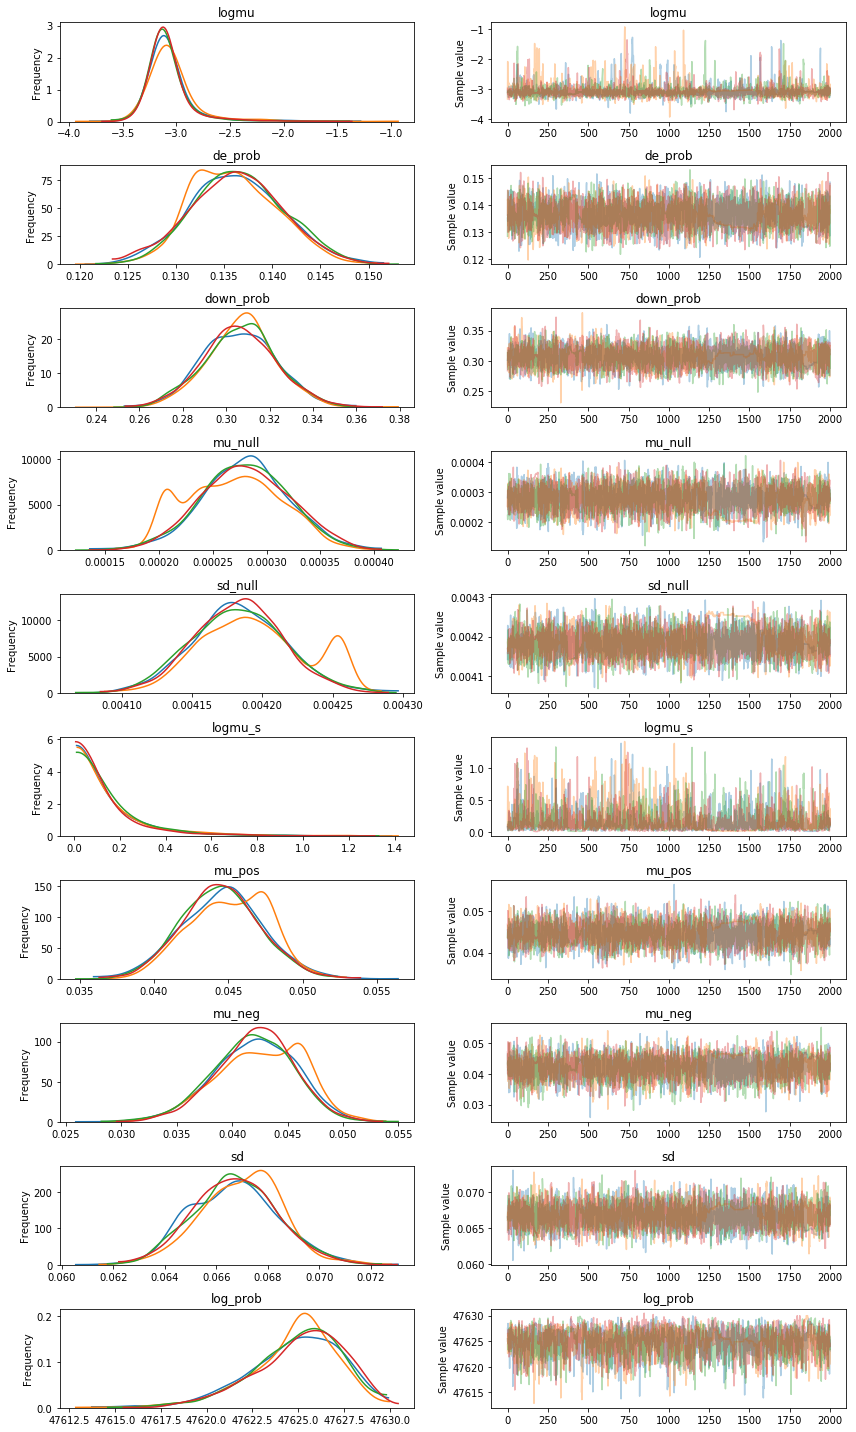

In [13]:
pm.plots.traceplot(trace)

In [ ]:
plot_posterior_predictive(ppc, fun1 = lambda x: np.mean(x, axis = 1), 
                          fun2 = lambda x: np.mean(x), 
                          xlab = "mean(x)",
                          title = "Posterior predictive of mean")

In [ ]:
plot_posterior_predictive(ppc, fun1 = lambda x: np.var(x, axis = 1), 
                          fun2 = lambda x: np.var(x), 
                          xlab = "var(x)",
                          title = "Posterior predictive of variance")

In [ ]:
plot_posterior_predictive(ppc, fun1 = lambda x: statsmodels.stats.stattools.robust_skewness(x, axis = 1)[3], 
                          fun2 = lambda x: statsmodels.stats.stattools.robust_skewness(x)[3], 
                          xlab = "skew(x)",
                          title = "Posterior predictive of robust skewness")